In [18]:
import numpy as np
from karabo.imaging.imager_oskar import OskarDirtyImager
from karabo.imaging import imager_wsclean
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.visibility import Visibility
from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.simulator_backend import SimulatorBackend
from karabo_simutils import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta
import xarray as xr
from matplotlib.colors import PowerNorm
#mpl.use('Tkagg')
%matplotlib inline
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

0.0003333333465789
43.014027


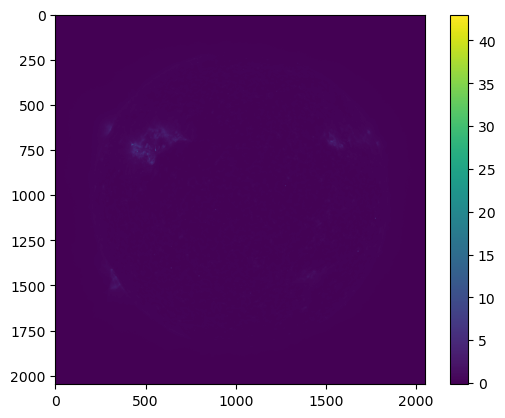

In [ ]:
# sc1: Surajit Model 

#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
#telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
telescope_path = '/data/rohit/skao_repo/ska1low.tm'
#telescope_name= 'sc1_100MHz'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['skalow','skamid','mwa','meerkat']
ska_aa_list = ['AA0.5','AA1','AA2','AAs','Full']
mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`

#---------
skymodel_path='/data/rohit/solar-sky-models/solar_image_model.fits'
#skymodel_path='/data/rohit/solar-sky-models/mark_skymodels/muram_560000_los0_grff.ncdf'
path = '/data/rohit/ska-solar-sim-repo-paper/'

ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
skymodel_cellsize=22.5 # in arcsec

#-------- Define Image Parameters
#npix_per_beam = 3
imgsize=4096
cellsize_arcsec=1 #beam_size_arcsec/npix_per_beam
cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
imager_str = 'wsclean'
niter = 18000
maxuv = 9000 # in lambda units
minuv = 10 # in lambda units
nchan = 1
ntchan = 1
weight = 'uniform'
smdata1, smhead1 = fits.getdata(skymodel_path,header=True)
smdata1 = smdata1[0][0]
print(smhead1['CDELT2'])
print(smdata1.max())
plt.imshow(smdata1)
plt.colorbar()
plt.savefig(skymodel_path+'.png')

i=0
freq_list = [100,500,1500,3000]
start_frequency_hz_ = freq_list[i]*1.e6
beam_size_arcsec = 180
print('Beam (arcsec)',beam_size_arcsec)
print("Frequency (MHz): ",start_frequency_hz_)
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
solar_map=smdata1
solar_map_jy=solar_map#/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
dec_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
ra_grid,dec_grid=np.meshgrid(ra_arr*smhead1['CDELT1'],dec_arr*smhead1['CDELT2'])
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten();flux=solar_map_jy.flatten()
print(sky_model_dec.shape,flux.shape,smhead1['CDELT1'],smhead1['CUNIT1'],sky_model_ra)

ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"# Simulation starts 
sky = SkyModel()
sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
                    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),\
                    np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
#sky_data=sky_data[0:16000,:]
sky.add_point_sources(sky_data)
#telescope_name="SKA1MID"
#telescope=Telescope.get_SKA1_LOW_Telescope()
#dtime=datetime(2000, 1, 1, 10, 0, 00, 0) # MeerKAT/ SKA-mid
dtime=datetime(2000, 1, 1, 4, 0, 00, 0) # MWA / SKA-low
backend=SimulatorBackend.OSKAR
#telescope = Telescope.constructor(telescope_name, backend=backend)
telescope=Telescope.read_OSKAR_tm_file(telescope_path)
telescope.read_OSKAR_tm_file(telescope_path)
simulation = InterferometerSimulation(vis_path=vis_filename, ms_file_path=ms_filename,
    channel_bandwidth_hz=1, time_average_sec=10, noise_enable=noise_enable_, use_gpus=True,
    noise_seed="time", noise_freq="Range", noise_rms="Range", 
    noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
    noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
    enable_array_beam=enable_array_beam) 
observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
    length=timedelta(hours=hour_, minutes=minutes_, seconds=0, milliseconds=0), 
    phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
    start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
    number_of_channels=nchan, ) 
visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)
npix_per_beam = 3
imgsize=4096
cellsize_arcsec=1 #beam_size_arcsec/npix_per_beam
cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
print('Cellsize:',cellsize_arcsec,'Beam (arcsec):',beam_size_arcsec,'Max length:')
print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
dirty_imager = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=imgsize,
        imaging_cellsize=cellsize_rad,
    ))
dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_oskar.fits"
dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)
dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_wsclean.fits"
img_cmd = 'wsclean \
        -size '+str(imgsize)+' '+str(imgsize)+' \
        -name '+dirty_wsclean_img+' \
        -scale '+str(cellsize_rad)+'rad -niter 5000 -mgain 0.8 \
        -weight uniform\
        -maxuv-l 90000 -minuv-l 10\
        -channels-out '+str(nchan)+' '+ms_filename
print(img_cmd)
try:
    restored = imager_wsclean.create_image_custom_command(command=img_cmd)
except:
    pass # doing nothing on exception    

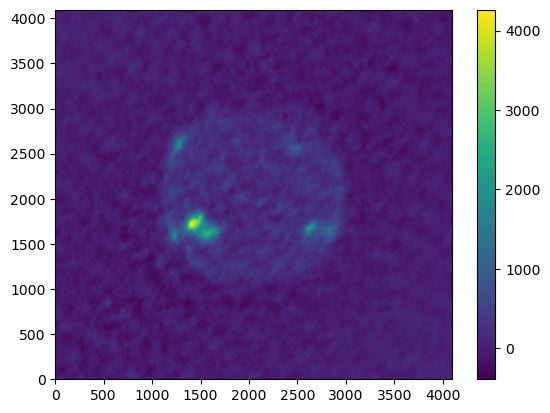

In [15]:
dirty_wsclean_img = '/data/rohit/ska-solar-sim-repo-paper/solar_freq_100_sc1_100MHz_wsclean.fits'
mapsun = fits.getdata(dirty_wsclean_img+'-image.fits')[0][0]
# Plot the results 
f,ax=plt.subplots(1,1)
im=ax.imshow(mapsun,aspect='auto', origin='lower')
f.colorbar(im)

0.002365436370203547


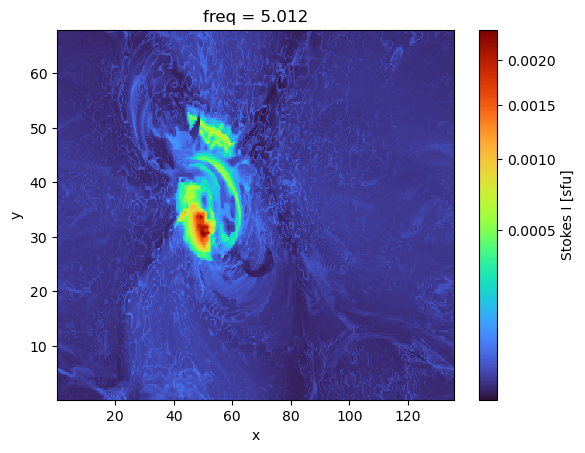

In [87]:
#sc2: Mark's Model 

#telescope_path = '/media/rohit/sdata/ska-solar-files/meerkat.tm'
telescope_path = '/data/rohit/skao_repo/ska1mid.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AAstar.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA2.tm'
#telescope_path = '/data/rohit/skao_repo/ska-mid-AA1.tm'
#telescope_path = '/media/rohit/sdata/ska-solar-files/mwa.phase1.tm'
#telescope_path = '/data/rohit/skao_repo/ska1low.tm'
telescope_name= 'sc2_2000MHz'
hour_=0
minutes_=1
noise_enable_ = False
enable_array_beam=False
skao_repo_tel_path = '/data/rohit/skao_repo/'
tel_all = get_telescope(skao_repo_tel_path) # 0 is SKA, and 1 is SKA-precursor
telescope_list = ['skalow','skamid','mwa','meerkat']
ska_aa_list = ['AA0.5','AA1','AA2','AAs','Full']
mid_bands=['1','3']
nt=1; tel = telescope_list[nt] # Put in your telescope in `tel`
ds = xr.load_dataset('/data/rohit/solar-sky-models/mark_skymodels/muram_530000_los0_grff.ncdf')
smdata2 = ds['Stokes I'].sel(freq=5, method='nearest').T.data[50:250,80:280]
print(smdata2.max())
ds['Stokes I'].sel(freq=5, method='nearest').T.plot(norm=PowerNorm(0.5), cmap='turbo')
dsx=ds['x']
res_sm2=dsx.data[1]-dsx.data[0] # in arcsec

Cellsize: 0.017655172413793104 Beam (arcsec): 180 Max length:
Field of View (deg): 0.020087662835249043
Frequency (MHz):  5000000000.0
(40000,) (40000,) [249.13431035 249.13438391 249.13445747 ... 249.1488023  249.14887586
 249.14894943] 23.654363702035468


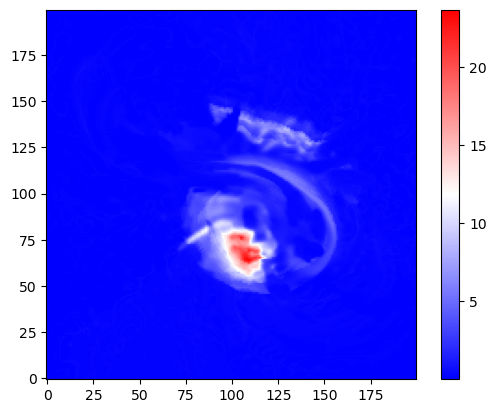

In [101]:
path = '/data/rohit/ska-solar-sim-repo-paper/'

ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
skymodel_cellsize=22.5 # in arcsec

#-------- Define Image Parameters
#npix_per_beam = 3
imgsize=4096
cellsize_arcsec=res_sm2/15 #beam_size_arcsec/npix_per_beam
cellsize_rad=cellsize_arcsec/3600*np.pi/180 # in rad
print('Cellsize:',cellsize_arcsec,'Beam (arcsec):',beam_size_arcsec,'Max length:')
print('Field of View (deg):',imgsize*cellsize_arcsec/3600.)
imager_str = 'wsclean'
niter = 18000
maxuv = 9000 # in lambda units
minuv = 10 # in lambda units
nchan = 1
ntchan = 1
weight = 'uniform'


i=4
freq_list = [100,500,1500,2000,5000]
start_frequency_hz_ = freq_list[i]*1.e6
print("Frequency (MHz): ",start_frequency_hz_)
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"
solar_map=smdata2
solar_map_jy=solar_map*1.e4#/np.nanmax(solar_map)*20*1.e4*(start_frequency_hz_/2.4e8)**1
ra_sun_center=249.141666667;dec_sun_center=21.986 #16 34 34.52 -21 59 09.7
ra_arr=(np.arange(solar_map_jy.shape[0])-int(solar_map_jy.shape[0]/2))
dec_arr=(np.arange(solar_map_jy.shape[1])-int(solar_map_jy.shape[1]/2))
ra_grid,dec_grid=np.meshgrid(ra_arr*res_sm2/3600.,dec_arr*res_sm2/3600.)
ra_grid=ra_grid+ra_sun_center;dec_grid=dec_grid+dec_sun_center
sky_model_ra=ra_grid.flatten();sky_model_dec=dec_grid.flatten();flux=solar_map_jy.flatten()
print(sky_model_dec.shape,flux.shape,sky_model_ra,solar_map_jy.max())
plt.imshow(solar_map_jy,origin='lower',cmap='bwr')
plt.colorbar()
plt.show()


In [102]:

#-----------
ms_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".ms"
vis_filename = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+".vis"# Simulation starts 
sky = SkyModel()
sky_data = np.array([sky_model_ra, sky_model_dec, flux,np.zeros(len(flux)), \
                    np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),\
                    np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux)), np.zeros(len(flux)),np.zeros(len(flux))]).T
#sky_data=sky_data[0:16000,:]
sky.add_point_sources(sky_data)
#telescope_name="SKA1MID"
#telescope=Telescope.get_SKA1_LOW_Telescope()
dtime=datetime(2000, 1, 1, 10, 0, 00, 0) # MeerKAT/ SKA-mid
#dtime=datetime(2000, 1, 1, 4, 0, 00, 0) # MWA / SKA-low
backend=SimulatorBackend.OSKAR
#telescope = Telescope.constructor(telescope_name, backend=backend)
telescope=Telescope.read_OSKAR_tm_file(telescope_path)
telescope.read_OSKAR_tm_file(telescope_path)
simulation = InterferometerSimulation(vis_path=vis_filename, ms_file_path=ms_filename,
    channel_bandwidth_hz=1, time_average_sec=10, noise_enable=noise_enable_, use_gpus=True,
    noise_seed="time", noise_freq="Range", noise_rms="Range", 
    noise_start_freq=1.e9, noise_inc_freq=1.e8, noise_number_freq=24, 
    noise_rms_start=0, noise_rms_end=0, enable_numerical_beam=enable_array_beam,
    enable_array_beam=enable_array_beam) 
observation = Observation(mode='Tracking',phase_centre_ra_deg=ra_sun_center, start_date_and_time=dtime, 
    length=timedelta(hours=hour_, minutes=minutes_, seconds=0, milliseconds=0), 
    phase_centre_dec_deg=dec_sun_center, number_of_time_steps=ntchan, 
    start_frequency_hz=start_frequency_hz_, frequency_increment_hz=1, 
    number_of_channels=nchan, ) 
visibility = simulation.run_simulation(telescope, sky, observation, backend=backend)
dirty_imager = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=imgsize,
        imaging_cellsize=cellsize_rad,
    ))
dirty_oskar_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_oskar.fits"
dirty_image = dirty_imager.create_dirty_image(visibility,output_fits_path=dirty_oskar_img)
dirty_wsclean_img = path+"solar_"+"freq_"+str(int(freq_list[i]))+'_'+telescope_name+"_wsclean.fits"
img_cmd = 'wsclean \
        -size '+str(imgsize)+' '+str(imgsize)+' \
        -name '+dirty_wsclean_img+' \
        -scale '+str(cellsize_rad)+'rad -niter 5000 -mgain 0.8 \
        -weight uniform\
        -maxuv-l 90000 -minuv-l 10\
        -channels-out '+str(nchan)+' '+ms_filename
print(img_cmd)
try:
    restored = imager_wsclean.create_image_custom_command(command=img_cmd)
except:
    pass # doing nothing on exception    

W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   
Saved visibility to /data/rohit/ska-solar-sim-repo-paper/solar_freq_5000_sc2_2000MHz.vis
wsclean         -size 4096 4096         -name /data/rohit/ska-solar-sim-repo-paper/solar_freq_5000_sc2_2000MHz_wsclean.fits         -scale 8.559469128554567e-08rad -niter 5000 -mgain 0.8         -weight uniform        -maxuv-l 90000 -minuv-l 10        -channels-out 1 /data/rohit/ska-solar-sim-repo-paper/solar_freq_5000_sc2_2000MHz.ms
Creating /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-gaIlgGX8AP for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-rohit-TRnaSBphUX/WSClean-custom-gaIlgGX8AP && OPENBLAS_NUM_THREADS=1 wsclean         -size 4096 4096         -name /data/rohit/ska-solar-sim-repo-paper/solar_freq_5000_sc2_2000MHz_wsclean.fits         -scale 8.559469128554567e-08rad -nite

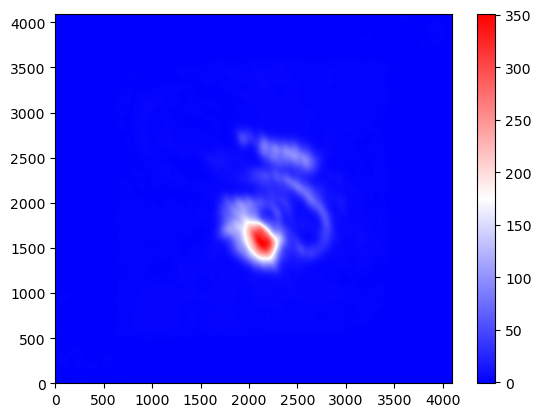

In [103]:
dirty_wsclean_img = '/data/rohit/ska-solar-sim-repo-paper/solar_freq_5000_sc2_2000MHz_wsclean.fits'
mapsun = fits.getdata(dirty_wsclean_img+'-image.fits')[0][0]/np.max(mapsun)*np.max(flux)
# Plot the results 
f,ax=plt.subplots(1,1)
im=ax.imshow(mapsun[:,::-1],aspect='auto', origin='lower',cmap='bwr')
f.colorbar(im)